In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("E://PHD/Course materials/Sem 1/Data Mining/Assignment/workspace/stock_price_trend_prediction/stock_price_pred_data_mining/Data/04_normalization_model_input/normalized_model_input.csv")

In [7]:
df.head(3)

,Date,stock_id,Open,High,Low,Close,Volume,MA7,MA21,EMA20,...,BB_upper,BB_middle,BB_lower,CCI_14,CMF_20,Stoch_K,Stoch_D,Momentum_10,Daily_Return,Log_Return
0,2021-12-14,ANANDRATHI,287.24,294.42,270.75,279.37,27861900.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,0.002398,0.002395
1,2021-12-15,ANANDRATHI,280.06,286.67,276.71,280.04,2675624.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,0.002398,0.002395
2,2021-12-16,ANANDRATHI,280.54,284.61,271.01,273.31,1329736.0,274.57858,284.5581,283.8015,...,257.13663,283.8015,310.46637,-4213.020993,-0.169092,80.29088,84.21576,-5.51,-0.024032,-0.024326


In [8]:
# Example: summarize each stock’s normalized indicators
cluster_features = (
    df
    .groupby('stock_id')
    .agg({
        'Close': ['mean', 'std', 'skew'],
        'Volume': ['mean', 'std'],
        'RSI_14': 'mean',
        'MACD': 'mean',
        'EMA20': 'mean',
        'BB_upper': 'mean',
        'BB_lower': 'mean',
        'Stoch_K': 'mean'
    })
)

# Flatten multi-index columns
cluster_features.columns = ['_'.join(col) for col in cluster_features.columns]
cluster_features.reset_index(inplace=True)


In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cluster_features.drop('stock_id', axis=1))
cluster_features['pca1'] = pca_features[:, 0]
cluster_features['pca2'] = pca_features[:, 1]

In [14]:
print(cluster_features.head())

     stock_id   Close_mean   Close_std  Close_skew   Volume_mean  \
0  ANANDRATHI  1171.873834  821.832909    0.306982  2.315982e+05   
1    AXISBANK   855.369206  236.601928   -0.196035  1.316032e+07   
2  BAJFINANCE   633.921412  171.692935   -0.609178  2.240856e+07   
3  BHARTIARTL   933.120435  460.312637    0.909550  1.055330e+07   
4        CAMS  2800.012810  900.615355    0.608367  2.796841e+05   

     Volume_std  RSI_14_mean  MACD_mean   EMA20_mean  BB_upper_mean  \
0  9.868963e+05    58.697560  19.559556  1145.217214    1059.640785   
1  1.101492e+07    52.230762   1.667351   852.784179     802.883356   
2  3.007266e+07    53.142327   2.900307   630.103011     588.005427   
3  1.309213e+07    55.138165   7.537872   923.369703     878.839196   
4  3.041229e+05    53.255856  14.454391  2779.615400    2570.470809   

   BB_lower_mean  Stoch_K_mean          pca1          pca2  cluster  
0    1230.211083     56.962060 -5.991799e+06 -1.564996e+05        1  
1     902.509444     54.

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = cluster_features.drop(['stock_id'], axis=1)
best_score = -1
best_k = None

for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k} → Silhouette Score = {score:.3f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best cluster count = {best_k}")

k=2 → Silhouette Score = 0.777
k=3 → Silhouette Score = 0.689
k=4 → Silhouette Score = 0.687
k=5 → Silhouette Score = 0.610
k=6 → Silhouette Score = 0.593
k=7 → Silhouette Score = 0.551
k=8 → Silhouette Score = 0.486
k=9 → Silhouette Score = 0.479
Best cluster count = 2


In [11]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_features['cluster'] = kmeans.fit_predict(X)

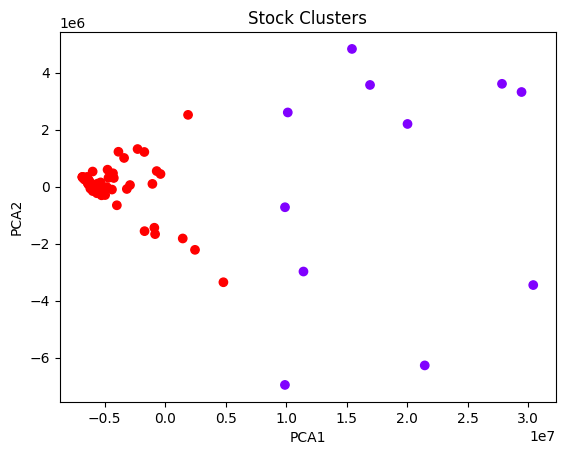

In [12]:
import matplotlib.pyplot as plt
plt.scatter(cluster_features['pca1'], cluster_features['pca2'], 
            c=cluster_features['cluster'], cmap='rainbow')
plt.title('Stock Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [13]:
cluster_summary = df.merge(cluster_features[['stock_id', 'cluster']], on='stock_id')
cluster_summary.groupby('cluster')['stock_id'].unique()

cluster
0    [AXISBANK, BAJFINANCE, BHARTIARTL, HDFCBANK, I...
1    [ANANDRATHI, CAMS, CASTROLIND, CDSL, CRIZAC, E...
Name: stock_id, dtype: object